In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import keras_cv
from keras import ops
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras import regularizers



In [11]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5
CROP_TO = 32
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Total training examples: 50000
Total test examples: 10000


In [12]:
strength = [0.4, 0.4, 0.4, 0.1]

random_flip = layers.RandomFlip(mode="horizontal_and_vertical")
random_crop = layers.RandomCrop(CROP_TO, CROP_TO)
random_brightness = layers.RandomBrightness(0.8 * strength[0])
random_contrast = layers.RandomContrast((1 - 0.8 * strength[1], 1 + 0.8 * strength[1]))
random_saturation = keras_cv.layers.RandomSaturation(
    (0.5 - 0.8 * strength[2], 0.5 + 0.8 * strength[2])
)
random_hue = keras_cv.layers.RandomHue(0.2 * strength[3], [0,255])
grayscale = keras_cv.layers.Grayscale()

def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = random_flip(image)
    image = random_crop(image)
    return image


def color_jitter(x, strength=[0.4, 0.4, 0.3, 0.1]):
    x = random_brightness(x)
    x = random_contrast(x)
    x = random_saturation(x)
    x = random_hue(x)
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = ops.clip(x, 0, 255)
    return x


def color_drop(x):
    x = grayscale(x)
    x = ops.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if keras.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

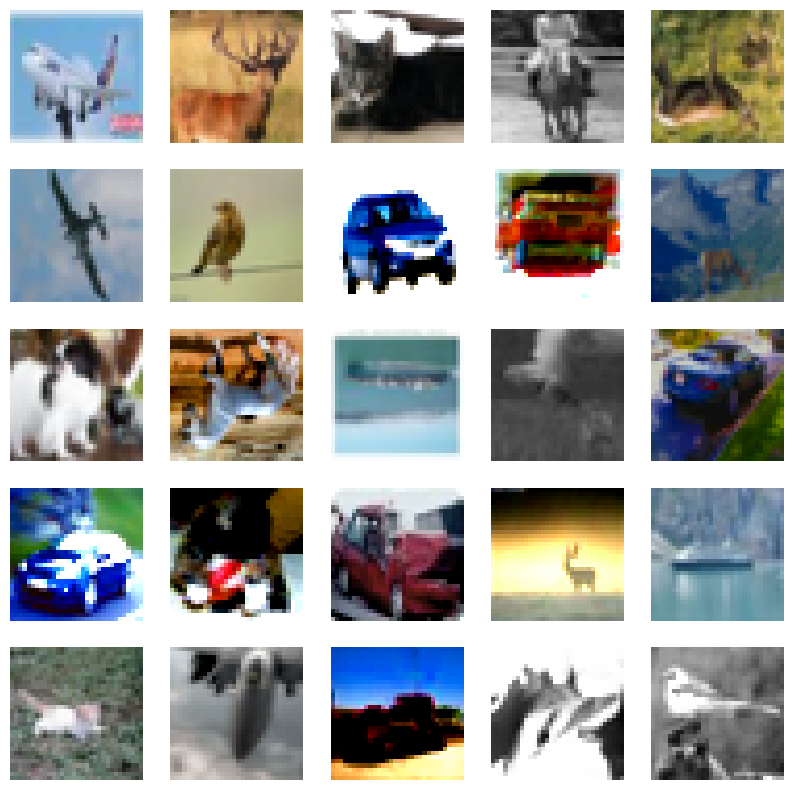

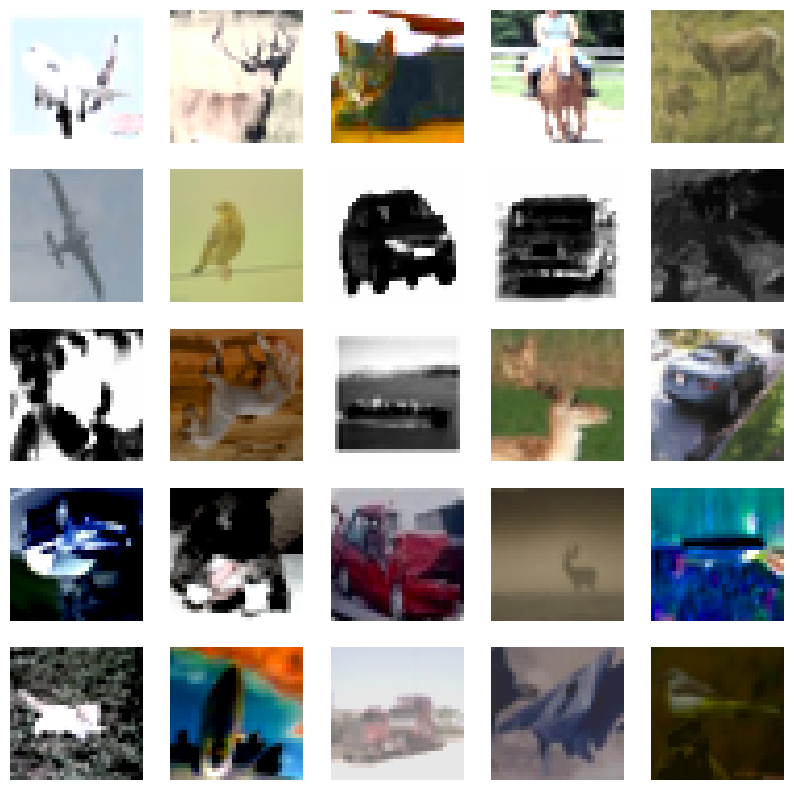

In [13]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [14]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [15]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder():
    # Input and backbone.
    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

In [16]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = ops.stop_gradient(z)
    p = keras.utils.normalize(p, axis=1, order=2)
    z = keras.utils.normalize(z, axis=1, order=2)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -ops.mean(ops.sum((p * z), axis=1))


In [17]:
class SimSiam(keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 784s 2s/step - loss: -0.8179
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - loss: -0.8899
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - loss: -0.8948
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - loss: -0.8965
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - loss: -0.8979


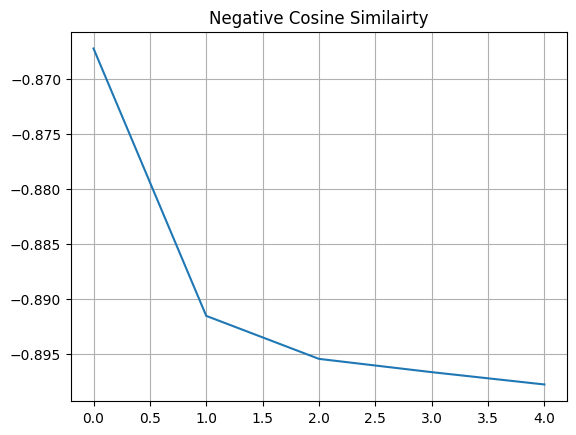

In [20]:
# Create a cosine decay learning scheduler.
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [21]:
#evaluation

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [23]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(10, activation="softmax")(x)
linear_model = keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 124s 307ms/step - accuracy: 0.1647 - loss: 2.2599 - val_accuracy: 0.2065 - val_loss: 2.1824
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 119s 304ms/step - accuracy: 0.2065 - loss: 2.1788 - val_accuracy: 0.2239 - val_loss: 2.1537
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 306ms/step - accuracy: 0.2178 - loss: 2.1567 - val_accuracy: 0.2333 - val_loss: 2.1422
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 122s 312ms/step - accuracy: 0.2240 - loss: 2.1469 - val_accuracy: 0.2342 - val_loss: 2.1380
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 121s 309ms/step - accuracy: 0.2263 - loss: 2.1442 - val_accuracy: 0.2286 - val_loss: 2.1373
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - accuracy: 0.2305 - loss: 2.1418
Test accuracy: 22.86%


79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step
              precision    recall  f1-score   support

           0     0.2740    0.5590    0.3678      1000
           1     0.2725    0.2300    0.2495      1000
           2     0.0935    0.0200    0.0329      1000
           3     0.1844    0.1160    0.1424      1000
           4     0.1258    0.0830    0.1000      1000
           5     0.2897    0.0310    0.0560      1000
           6     0.2036    0.7430    0.3196      1000
           7     0.2199    0.0950    0.1327      1000
           8     0.3007    0.1750    0.2212      1000
           9     0.2779    0.2340    0.2541      1000

    accuracy                         0.2286     10000
   macro avg     0.2242    0.2286    0.1876     10000
weighted avg     0.2242    0.2286    0.1876     10000



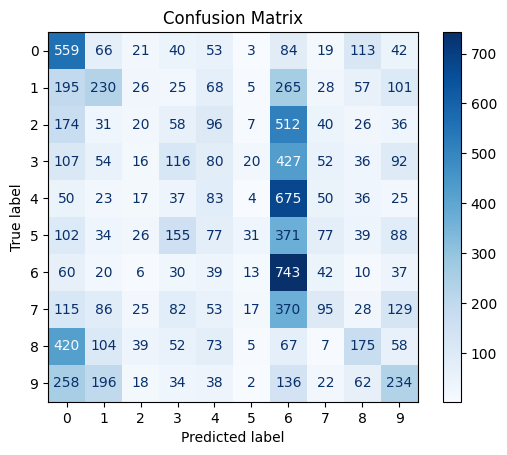

In [24]:
# Predict on test data
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = linear_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


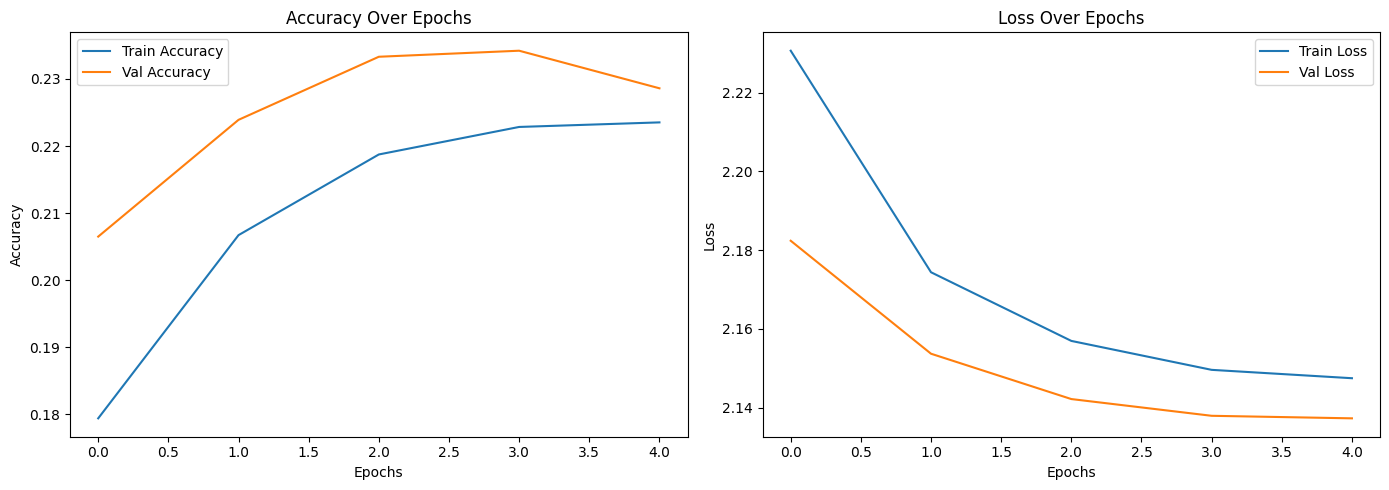

In [25]:
# Plot training history
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
